In [1]:
import sys  
sys.path.insert(0, '..')

In [2]:
import argparse

def get_args():
    parser = argparse.ArgumentParser(description=None)
    parser.add_argument('--input_dim', default=2, type=int, help='dimensionality of input tensor')
    parser.add_argument('--hidden_dim', default=200, type=int, help='hidden dimension of mlp')
    parser.add_argument('--learn_rate', default=1e-3, type=float, help='learning rate')
    parser.add_argument('--total_steps', default=2000, type=int, help='number of gradient steps')
    parser.add_argument('--name', default='pend', type=str, help='only one option right now')
    parser.add_argument('--field_type', default='solenoidal', type=str, help='type of vector field to learn')
    parser.set_defaults(feature=True)
    return parser.parse_args()

In [15]:
from hnn.simulation import get_dataset, get_field, get_trajectory
import torch
import matplotlib.pyplot as plt



In [4]:
from hnn.train import train

if __name__ == "__main__":
    args = get_args()
    model, stats = train(args)

/opt/homebrew/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/opt/homebrew/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/Users/kristinlindquist/development/pinns/src/hnn/../hnn/train.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(data["x"], requires_grad=True, dtype=torch.float32)
/Users/kristinlindquist/development/pinns/src/hnn/../hnn/train.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detac

step 0, train_loss 6.0259e+00, test_loss 5.5792e+00
step 1, train_loss 5.6965e+00, test_loss 5.2707e+00
step 2, train_loss 5.3819e+00, test_loss 4.9733e+00
step 3, train_loss 5.0791e+00, test_loss 4.6859e+00
step 4, train_loss 4.7872e+00, test_loss 4.4085e+00
step 5, train_loss 4.5057e+00, test_loss 4.1412e+00
step 6, train_loss 4.2343e+00, test_loss 3.8839e+00
step 7, train_loss 3.9728e+00, test_loss 3.6361e+00
step 8, train_loss 3.7206e+00, test_loss 3.3972e+00
step 9, train_loss 3.4769e+00, test_loss 3.1664e+00
step 10, train_loss 3.2409e+00, test_loss 2.9429e+00
step 11, train_loss 3.0121e+00, test_loss 2.7261e+00
step 12, train_loss 2.7898e+00, test_loss 2.5155e+00
step 13, train_loss 2.5735e+00, test_loss 2.3108e+00
step 14, train_loss 2.3632e+00, test_loss 2.1121e+00
step 15, train_loss 2.1589e+00, test_loss 1.9196e+00
step 16, train_loss 1.9609e+00, test_loss 1.7341e+00
step 17, train_loss 1.7699e+00, test_loss 1.5567e+00
step 18, train_loss 1.5870e+00, test_loss 1.3887e+00
ste

In [23]:

def get_vector_field(model, **kwargs):
    field = get_field(**kwargs)
    np_mesh_x = field['x']
    mesh_x = torch.tensor(np_mesh_x, requires_grad=True, dtype=torch.float32)
    mesh_dx = model.time_derivative(mesh_x)
    return mesh_dx.data.numpy()

import scipy.integrate
solve_ivp = scipy.integrate.solve_ivp

def integrate_model(model, t_span, y0, **kwargs):
    def fun(t, np_x):
        x = torch.tensor( np_x, requires_grad=True, dtype=torch.float32).view(1,2)
        dx = model.time_derivative(x).data.numpy().reshape(-1)
        return dx

    return solve_ivp(fun=fun, t_span=t_span, y0=y0, **kwargs)

/var/folders/0v/9bqjr621655_pg00r8l1nlzh0000gn/T/ipykernel_78819/2561085005.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mesh_x = torch.tensor(np_mesh_x, requires_grad=True, dtype=torch.float32)


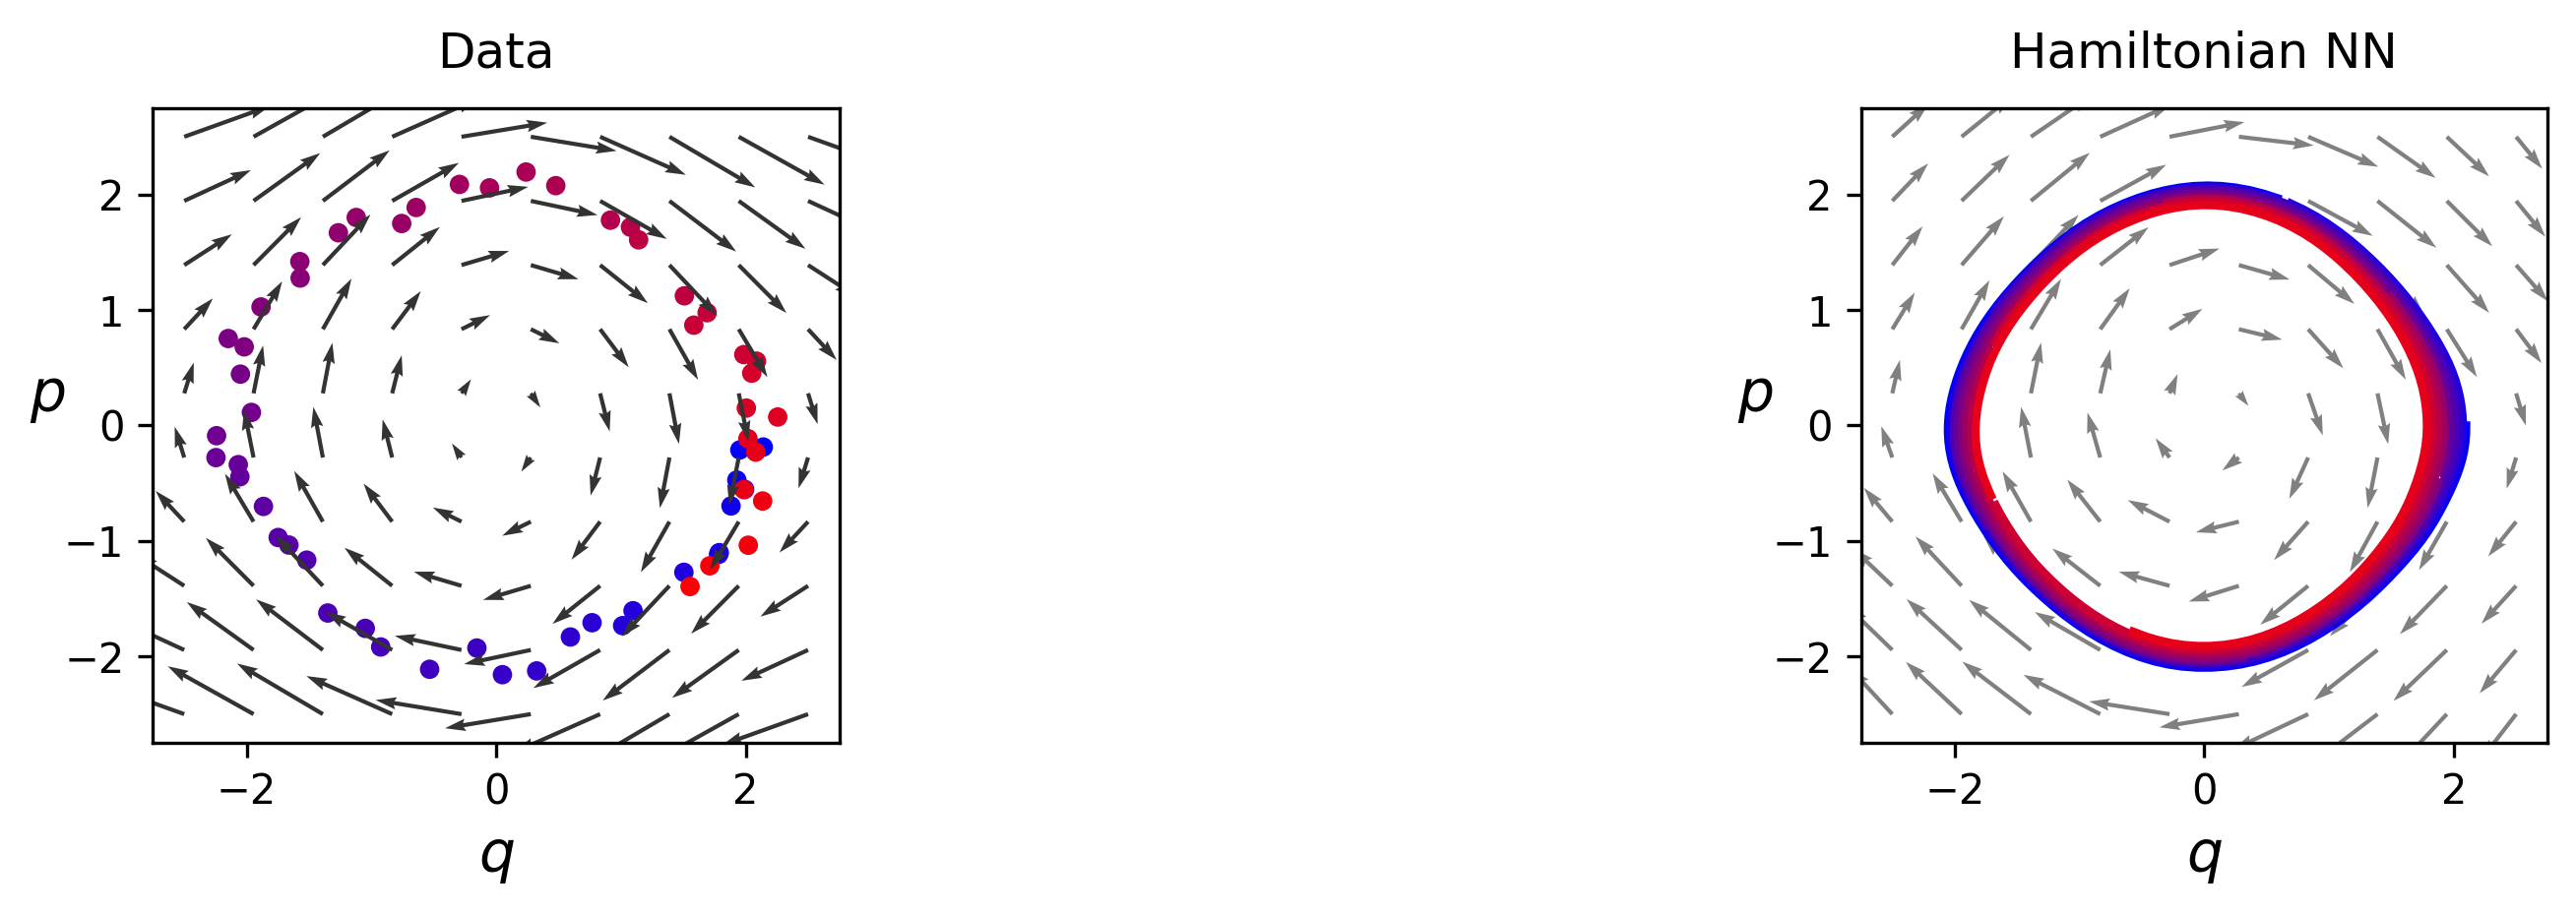

In [27]:
DPI = 300
FORMAT = 'pdf'
LINE_SEGMENTS = 10
ARROW_SCALE = 40
ARROW_WIDTH = 6e-3
LINE_WIDTH = 2
GRID_SIZE=10
R = 2.5


args = get_args()
field = get_field(xmin=-R, xmax=R, ymin=-R, ymax=R, gridsize=15)
data = get_dataset()
field = get_field(xmin=-R, xmax=R, ymin=-R, ymax=R, gridsize=GRID_SIZE)
data = get_dataset(radius=2.0)
vector_field = get_vector_field(model, xmin=-R, xmax=R, ymin=-R, ymax=R, gridsize=GRID_SIZE)

# integrate along those fields starting from point (1,0)
hnn_ivp = integrate_model(model, t_span=[0, 28], y0=torch.tensor([2.1, 0]), t_eval=torch.linspace(t_span[0], t_span[1], 1000), rtol=1e-12)

import numpy as np

###### PLOT ######
fig = plt.figure(figsize=(11.3, 3.2), facecolor='white', dpi=DPI)

# plot dynamics
fig.add_subplot(1, 4, 2, frameon=True)
x, y, dx, dy, t = get_trajectory(t_span=[0,4], radius=2.1, y0=y0)
N = len(x)
point_colors = [(i/N, 0, 1-i/N) for i in range(N)]
plt.scatter(x,y, s=14, label='data', c=point_colors)

plt.quiver(field['x'][:,0], field['x'][:,1], field['dx'][:,0], field['dx'][:,1],
        cmap='gray_r', scale=ARROW_SCALE, width=ARROW_WIDTH, color=(.2,.2,.2))  
plt.xlabel("$q$", fontsize=14)
plt.ylabel("$p$", rotation=0, fontsize=14)
plt.title("Data", pad=10)

# plot HNN
fig.add_subplot(1, 4, 4, frameon=True)
plt.quiver(field['x'][:,0], field['x'][:,1], hnn_field[:,0], hnn_field[:,1],
        cmap='gray_r', scale=ARROW_SCALE, width=ARROW_WIDTH, color=(.5,.5,.5))

for i, l in enumerate(np.split(hnn_ivp['y'].T, LINE_SEGMENTS)):
    color = (float(i)/LINE_SEGMENTS, 0, 1-float(i)/LINE_SEGMENTS)
    plt.plot(l[:,0],l[:,1],color=color, linewidth=LINE_WIDTH)

plt.xlabel("$q$", fontsize=14)
plt.ylabel("$p$", rotation=0, fontsize=14)
plt.title("Hamiltonian NN", pad=10)
plt.tight_layout() ; plt.show()
